In [22]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
from fpdf import FPDF
import os
from concurrent.futures import ThreadPoolExecutor

In [2]:
# Odczytaj wartość zmiennej z pliku
with open('przekazana_zmienna.txt', 'r') as f:
    przekazana_zmienna = f.read()

# Zapisanie numeru kadencji do zmiennej
przekazana_zmienna = int(przekazana_zmienna[-2:]) if przekazana_zmienna[-2].isdigit() else int(przekazana_zmienna[-1])

# Usunięcie pliku
os.remove('przekazana_zmienna.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'przekazana_zmienna.txt'

In [51]:
# Funkcja do zamiany nazwy miesiąca na numer
def Months(month):
    PL_months=('stycznia', 'lutego', 'marca', 'kwietnia', 'maja', 'czerwca', 'lipca', 'sierpnia', 'września', 'października', 'listopada', 'grudnia')
    return PL_months.index(month)+1

# Funkcja do konwersji daty na obiekt datetime
def duration(data):
    data2 = data.split(" ")
    data2[1]=Months(data2[1])
    data3=datetime.date(int(data2[2]),data2[1],int(data2[0]))
    return(data3)

In [53]:
#obsługa linku i wyliczenie czasu
def process_link(link):
    try:
        download2_html = requests.get(link)
        soup2 = BeautifulSoup(download2_html.text, 'html.parser')
        # obsługa różnego formatu strony w zależności od kadencji
        if int(przekazana_zmienna) > 6:
            full_table2 = soup2.body.find_all(class_='krok')
            full_table3 = soup2.body.find(class_="h2")
            tekst = full_table3.get_text()
            start = duration(full_table2[0].select_one('span').get_text())
            end = duration(full_table2[-2 if "krok koniec" in str(full_table2[-1]) else -1].select_one('span').get_text())
        else:
            full_table2 = soup2.body.find_all("b")
            tekst = full_table2[0].text
            for tresc in full_table2:
                if " wpłynął " in tresc.text:
                    try:
                        start = datetime.datetime.strptime(tresc.text.strip().split(" ")[1], '%d-%m-%Y')
                    except Exception as e:
                        print("Wystąpił błąd:", e)
                        print(link)
                        start = datetime.datetime.strptime(tresc.text.strip().split(" ")[1][:-2], '%d-%m-%Y')
                elif "podpisał" in tresc.text:
                    end = datetime.datetime.strptime(tresc.text.strip().split(" ")[1], '%d-%m-%Y')
        time = end - start
        return [tekst, time.days]
    except Exception as e:
        print("Wystąpił błąd:", e)
        print(link)
        return None

start_url = f"https://www.sejm.gov.pl/Sejm9.nsf/agent.xsp?symbol=USTAWYALL&NrKadencji={przekazana_zmienna}&NrPosiedzenia=9999"
download_html = requests.get(start_url)
soup = BeautifulSoup(download_html.text, 'html.parser')
with open('downloaded.html', 'w', encoding="utf-8") as file:
    file.write(soup.prettify())

link = soup.find_all(class_='proc')
data = []
print(link)
#wielowątkowosć
with ThreadPoolExecutor(max_workers=10) as executor:
    results = executor.map(process_link, [item.get("href") for item in link])

# Licznik łącznej liczby dni procedowania ustaw
total_days = 0


for result in results:
    if result:
        data.append(result)
        total_days += result[1] # Dodaj liczbę dni procedowania ustaw do łącznej liczby dni


data.sort(key=lambda x: x[1])  # Sortowanie po kolumnie 'Dni'


#zapisanie zmiennych jako tabeli

df = pd.DataFrame(data, columns=['Nazwa ustawy:', 'Dni'])
#usuwanie tymczasowego pliku

os.remove("downloaded.html")


[]


In [40]:
avg_time = total_days // len(df) #średni czas uchwalania ustaw

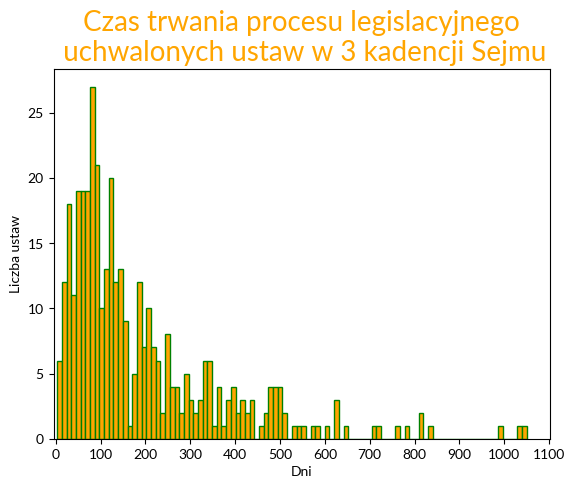

In [41]:
# Tworzenie histogramu
plt.rcParams['font.family'] = 'Lato'
plt.hist(df['Dni'], bins=100, color='orange', edgecolor='green')
plt.title(f"Czas trwania procesu legislacyjnego\n uchwalonych ustaw w {przekazana_zmienna} kadencji Sejmu", fontsize=20, color="orange")
plt.ylabel('Liczba ustaw')
plt.xlabel('Dni')

# Ustawienie ograniczeń osi x i y
longest = df['Dni'].max()
plt.xlim(-5, math.ceil(longest / 100.0) * 100 + 1)
plt.xticks(range(0, math.ceil(longest / 100.0) * 100 + 1, 100))

# Zapisanie wykresu do pliku
plt.savefig('wykres.png', bbox_inches='tight')

In [42]:
# Sortowanie danych
df = df.sort_values(by=['Dni'])
longest = df.tail(1).values[0]
fastest = df.iloc[0].values

In [48]:
def header(text):
        pdf.set_text_color(255, 165, 0)
        pdf.set_font('Lato', 'B', 20)        
        pdf.cell(0, 10, text.upper(), align='C', ln=True)
        pdf.set_font('Lato', '', 12)  # Ustawienie niestandardowej czcionki
        pdf.set_text_color(0,0,0)


# Tworzenie nowego dokumentu PDF
pdf = FPDF()
pdf.add_page()


pdf.add_font('lato', 'B', 'Lato-Bold.ttf')  # Dodanie niestandardowej czcionki
pdf.add_font('Lato', '', 'Lato-Regular.ttf')  # Dodanie niestandardowej czcionki
pdf.set_font('Lato', '', 12)  # Ustawienie niestandardowej czcionki

header(f"Długość procedowania ustaw w {przekazana_zmienna} kadencji Sejmu")

# Zawartość dokumentu
pdf.write(4, f"\nŁącznie w tej kadencji Sejmu zostało uchwalonych {len(link)} ustaw.\n")
pdf.write(4, f"\nŚredni czas trwania procesu legislacyjnego wynosi {avg_time} dni.\n")
pdf.write(4, f"\nUstawa, której proces legislacyjny trwał najdłużej to: {longest[0]}, której proces trwał {longest[1]} dni.\n")
pdf.write(4, f"\nUstawa, której proces legislacyjny trwał najszybciej to: {fastest[0]}, której proces trwał {fastest[1]} dni.\n")



pdf.ln(10)
page_width = pdf.w - 2 * pdf.l_margin  #Szerokość strony minus marginesy
pdf.image('wykres.png',w=page_width)
pdf.add_page()
# Nagłówek tabeli
header('Tabela ustaw')

# Tabela
pdf.set_fill_color(255, 165, 0)
pdf.cell(170, 10, 'Nazwa ustawy', border=1,align='C',fill=True )  # Szerokość pierwszej kolumny
pdf.cell(20, 10, 'Dni', border=1,align='C',fill=True),  # Szerokość drugiej kolumny
pdf.ln()

# Wypełnienie tabeli danymi z DataFrame
for index, row in df.iterrows():

 # Ustawienie położenia X (poziomego) na 10 jednostek
    ybefore = pdf.get_y()
    pdf.multi_cell(170, 6, str(row['Nazwa ustawy:']), border=1, align='J')  # Pierwsza kolumna
    yafter = pdf.get_y()
    if ybefore>yafter:
        ybefore=10
    pdf.set_xy(180, ybefore)
    pdf.cell(20, yafter-ybefore, str(row['Dni']), border=1, align='C')  # Druga kolumna
    pdf.set_xy(10, yafter)
    
# Zapisanie do pliku
pdf.output('plik.pdf')

C:\Users\slowa\AppData\Local\Temp\ipykernel_7872\2845170063.py:4: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 10, text.upper(), align='C', ln=True)


In [49]:
%run zapis.ipynb

Plik został zapisany jako: C:/Users/slowa/Downloads/test.pdf
